In [1]:
from scanner import *
from preprocessor import *
from matcher import *

from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

import time

### Assumptions

1. Every edge for every building is divided into subparts if the length is very large. For example, a stadium's edge even though it is straight, will be divided into multiple edges to make sure the edge is detected in the scanner. This is required as the scanner's range is restricted. Doing this has no performance hit as the bottleneck is the number of features in edge, so the splitting has no performance hit on ***this*** algorithm.
2. Buildings are convex. If not, split the building into convex parts and the overlapping edges with no feature points

### Algorithm

- Tag all nodes, edges based on FOV
- Find all the buildings that are there in the given FOV
    - A building is visible if either the edge is tagged in FOV or the vertex is tagged in FOV
- For all buildings get the frontier set of edges based on the ORIGIN
- Valid edges are current all edges that are tagged in FOV as well as in the frontier.
- Remove edges from this set that are overshadowed
- Calculate the effective scope of each building
- For every building scope, remove edges that are overshadowed by this scope

reference_angle :  45.00000000000001
semicircle_angle_start :  -44.99999999999999
semicircle_angle_end:  135.0
fov_angle_start:  7.105427357601002e-15
fov_angle_end:  90.0
reverse_fov_angle_start:  -90.0
reverse_fov_angle_end:  180.0
spans
{2: [39, 40], 3: [44, 41], 4: [54, 51]}



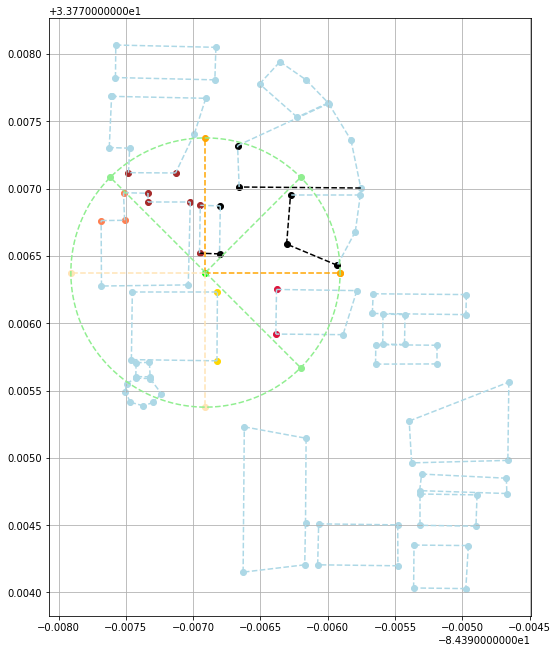

In [2]:
if ORIGINAL_DATA:
    radius = 0.001

    data = {
        "TG": [[33.77435829374495, -84.397344643052], [1, 0]],
        "BusStop": [[33.7754096889298, -84.39580062968061], [0, -1]],
        "Hive1": [[33.77567129853454, -84.39715893627394], [1, 1]],
        "Hive2": [[33.77567129853454, -84.39715893627394], [-1, -1]],
        "Pettit": [[33.77637681793485, -84.39690871277799], [1, 1]],
        "Klaus1": [[33.77692237952651, -84.39637874707857], [1, 1]],
        "Klaus2": [[33.77692237952651, -84.39637874707857], [-1, 1]],
        "IndustrialDesign": [[33.77570781753953, -84.39607218474292], [1, 1]],
        "CULC": [[33.773985, -84.396579], [0, 1]]
    }
    origin, direction = data["Pettit"]
    origin.reverse()
    DIFF = 0.001
else:
    radius = 6.5
    origin = [4, 4]

    DIFF = 0.1
    direction = [1, 1]

edges = tag_edges_by_view(origin, direction, radius)

In [3]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def print_img(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.show()

In [5]:
def match_feature_points(d1, d2, mode=""):
    if mode == "flann":
        start = time.time()
        
        flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict())
        
        end = time.time()
        print("Flann Matching took ", end-start, " seconds.")
        return flann.knnMatch(d1, d2, k=2)
    else:
        start = time.time()
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        matches = bf.match(d1,d2)
        matches = sorted(matches, key = lambda x:x.distance)

        end = time.time()
        print("Matching took ", end-start, " seconds.")
        return matches

In [6]:
def get_score(matches, k1, k2):
    return len(matches)/min(len(k1), len(k2))

Features took  2.002441167831421  seconds.


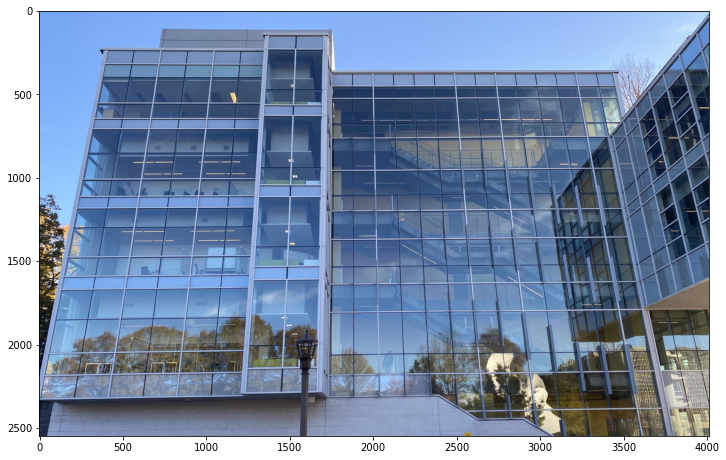

Features took  1.7466099262237549  seconds.


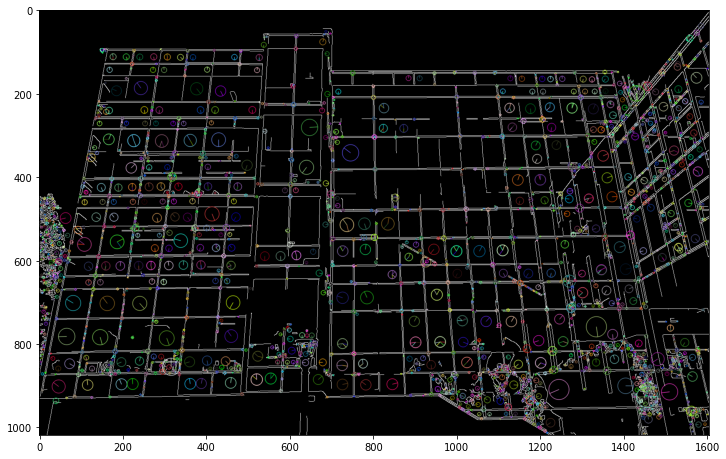

Features took  0.19274497032165527  seconds.


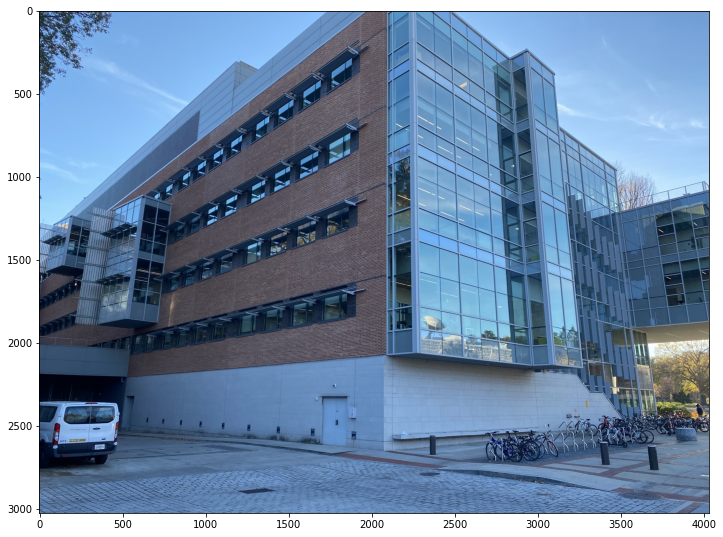

Features took  2.770854949951172  seconds.


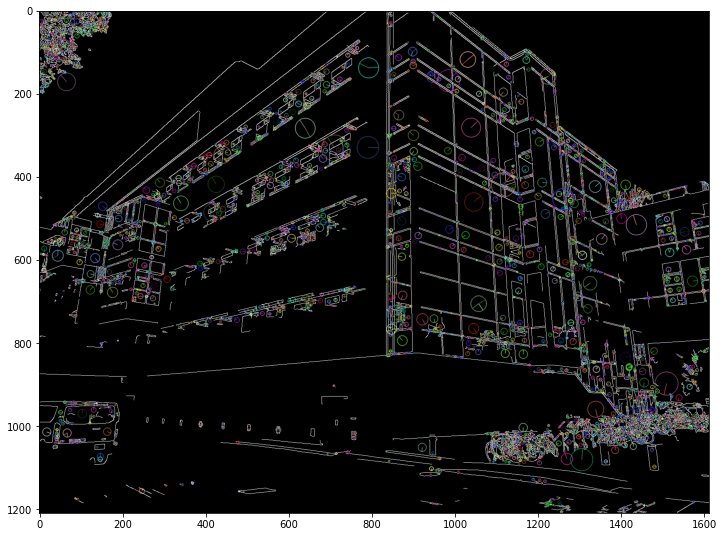

In [7]:
img1 = read_img("images/f1.jpeg")
# print_img(img1)
k1, d1, i1 = get_features(img1)
# print_img(i1)

img2 = read_img("images/f2.jpeg")
print_img(img2)
k2, d2, i2 = get_features(img2)
print_img(i2)

img3 = read_img("images/f3.jpeg")
# print_img(img3)
k3, d3, i3 = get_features(img3)
# print_img(i3)

img = read_img("images/example.jpeg")
print_img(img)
k, d, i = get_features(img)
print_img(i)

Matching took  1.0233161449432373  seconds.
Matching took  0.3782989978790283  seconds.
Matching took  0.006846904754638672  seconds.
0.29672959319329967


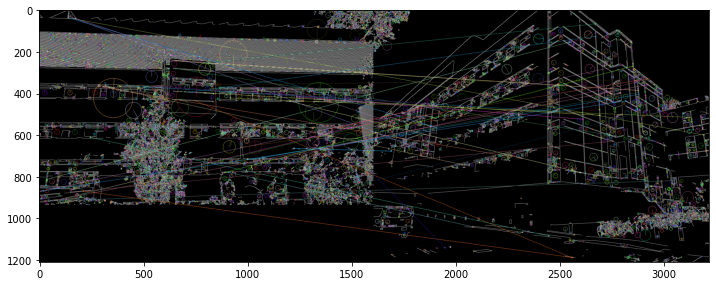

0.21444479796372892


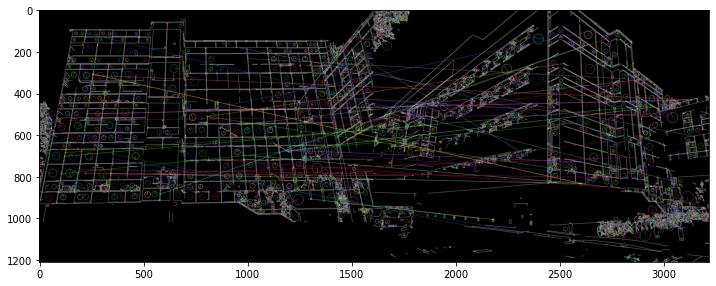

0.9152542372881356


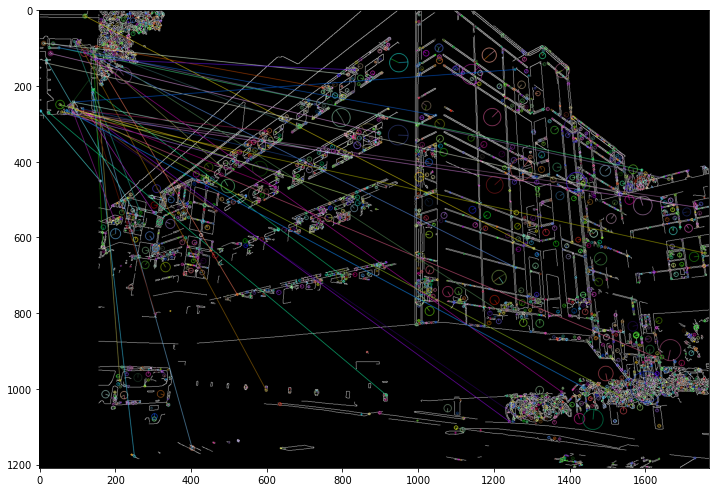

In [8]:
mode = ""

m1 = match_feature_points(d1, d, mode)
m2 = match_feature_points(d2, d, mode)
m3 = match_feature_points(d3, d, mode)

imgm1 = cv2.drawMatches(i1, k1, i, k, m1[:50], i, flags=2)
imgm2 = cv2.drawMatches(i2, k2, i, k, m2[:50], i, flags=2)
imgm3 = cv2.drawMatches(i3, k3, i, k, m3[:50], i, flags=2)

print(get_score(m1, k1, k))
print_img(imgm1)
print(get_score(m2, k2, k))
print_img(imgm2)
print(get_score(m3, k3, k))
print_img(imgm3)

Flann Matching took  3.504753112792969e-05  seconds.
Flann Matching took  1.0013580322265625e-05  seconds.
Flann Matching took  1.0967254638671875e-05  seconds.
1.8011167242754587


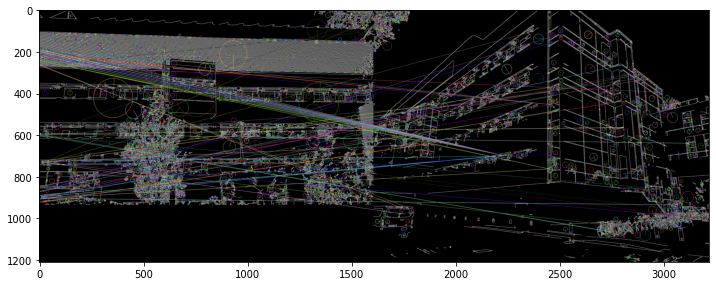

1.0


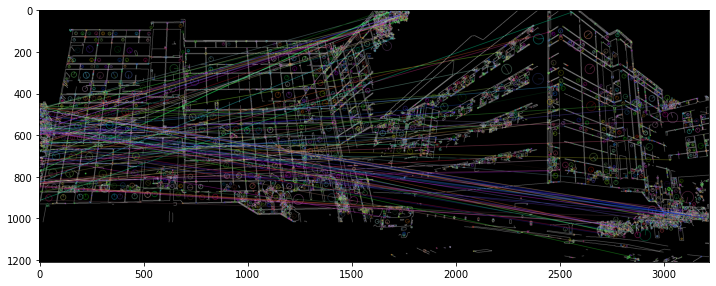

1.0


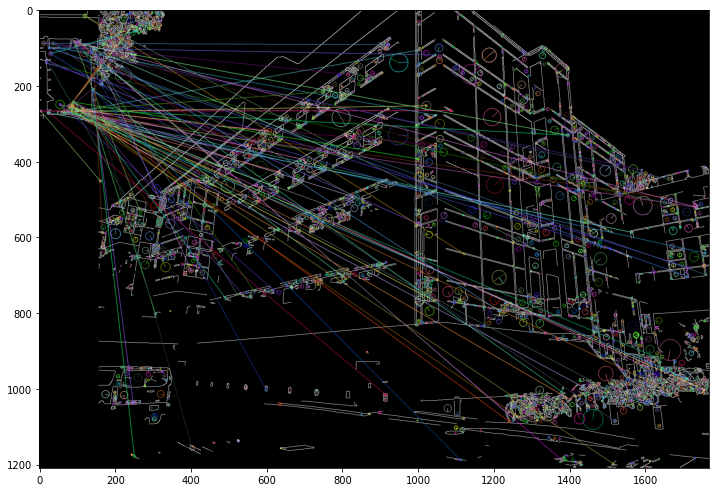

In [9]:
mode = "flann"

m1 = match_feature_points(d1, d, mode)
m2 = match_feature_points(d2, d, mode)
m3 = match_feature_points(d3, d, mode)

imgm1 = cv2.drawMatchesKnn(i1, k1, i, k, m1[:50], i, flags=2)
imgm2 = cv2.drawMatchesKnn(i2, k2, i, k, m2[:50], i, flags=2)
imgm3 = cv2.drawMatchesKnn(i3, k3, i, k, m3[:50], i, flags=2)

print(get_score(m1, k1, k))
print_img(imgm1)
print(get_score(m2, k2, k))
print_img(imgm2)
print(get_score(m3, k3, k))
print_img(imgm3)

In [10]:
mode = "flann"

m1 = match_feature_points(d1, d, mode)
m2 = match_feature_points(d2, d, mode)
m3 = match_feature_points(d3, d, mode)

imgm1 = cv2.drawMatchesKnn(i1, k1, i, k, lowes_ratio_test_filter(m1), i, flags=2)
imgm2 = cv2.drawMatchesKnn(i2, k2, i, k, lowes_ratio_test_filter(m2), i, flags=2)
imgm3 = cv2.drawMatchesKnn(i3, k3, i, k, lowes_ratio_test_filter(m3), i, flags=2)

print(get_score(m1, k1, k))
print_img(imgm1)
print(get_score(m2, k2, k))
print_img(imgm2)
print(get_score(m3, k3, k))
print_img(imgm3)

Flann Matching took  1.3828277587890625e-05  seconds.
Flann Matching took  1.0967254638671875e-05  seconds.
Flann Matching took  8.821487426757812e-06  seconds.


error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'drawMatchesKnn'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
